Javier García Serrano, Ana Gil Molina

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 3:  (3 puntos)</strong></div>

**Usando los datasets de la página de [Anki](https://www.manythings.org/anki/), repetir los experimentos para crear traductores con atención de Bahdanau, del italiano al inglés y del castellano al inglés. Haz uso del cluster para producir los modelos. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.**

In [ ]:
!pip install nltk
import nltk

In [9]:
import os

# Cambiar el directorio
os.chdir("C:/Users/gilpe/Desktop/Máster IA/Primer cuatrimestre/Deep Learning para Procesamiento del Lenguaje Natural/Parte I/Práctica/Datos")
print("Directorio actual:", os.getcwd())

Directorio actual: C:\Users\gilpe\Desktop\Máster IA\Primer cuatrimestre\Deep Learning para Procesamiento del Lenguaje Natural\Parte I\Práctica\Datos


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocesamiento de los Datos

Una vez descargados los datasets de la página de [Anki](https://www.manythings.org/anki/), deben ser preprocesados, ya que inicialmente los datos tienen la forma:

English + TAB + The Other Language + TAB + Attribution

Para crear los traductores, debemos eliminar la atribución, de forma que los datos queden de la forma:

English + TAB + The Other Language

Para ello, se puede usar la siguiente función, que elimina la atribución de cada frase:

In [2]:
def preprocess_dataset(input_file, output_file):
    """
    Procesa un dataset eliminando la atribución.
    Args:
        input_file (str): Ruta del archivo de entrada (dataset).
        output_file (str): Ruta del archivo de salida preprocesado.
    """
    # Abrir el archivo de entrada
    with open(input_file, 'r', encoding='utf-8') as infile:
        # Crear y abrir el archivo de salida en modo escritura
        with open(output_file, 'w', encoding='utf-8') as outfile:
            for line in infile:
                # Dividir la línea en columnas usando tabulación como separador
                sentences = line.split('\t')
                # Extraer las frases en ambos idiomas y escribirlas
                lang1 = sentences[0].strip()
                lang2 = sentences[1].strip()
                outfile.write(f"{lang1}\t{lang2}\n")
    print(f"Archivo preprocesado guardado en: {output_file}")

In [4]:
# Rutas para preprocesar los datos de inglés a italiano
input_file = os.path.join("data/", "ita.txt")
output_file = os.path.join("data/", "eng-ita.txt")

# Llamada a la función
preprocess_dataset(input_file, output_file)

Archivo preprocesado guardado en: data/eng-ita.txt


In [5]:
# Rutas para preprocesar los datos de inglés a castellano
input_file = os.path.join("data", "spa.txt")
output_file = os.path.join("data", "eng-spa.txt")

# Llamada a la función
preprocess_dataset(input_file, output_file)

Archivo preprocesado guardado en: data\eng-spa.txt


Cada palabra se representará con un vector one-hot. Se necesitará un único índice para cada palabra, y mediante la clase `Lang` podremos llevar la cuenta de todos en cada lenguaje gracias a los diccionarios `word2index` e `index2word`. Además, para conocer la frecuencia de cada palabra y eliminar aquellas de menor frecuencia, usaremos `word2count`. El número de palabras se almacenará en `n_words`.

In [3]:
SOS_token = 0       # Asignar índice 0 al token SOS inicial
EOS_token = 1       # Asignar índice 1 al token EOS final

class Lang:
    def __init__(self, name):
        self.name = name  # Nombre del idioma
        self.word2index = {}  # Palabra -> índice
        self.word2count = {}  # Palabra -> cantidad de veces que aparece
        self.index2word = {0: "SOS", 1: "EOS"}  # Índice -> palabra
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Como todos los ficheros son unicode, simplificaremos las cosas pasando todo a ASCII, minúsculas, y eliminando todos los signos de puntuación.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Mediante la función `readLangs` separamos ficheros en líneas, y las líneas en pares. Los ficheros contienen sentencias del inglés a otros lenguajes. Como en nuestro caso vamos a traducir del italiano al inglés, y del castellano al inglés, deberemos poner `reverse = True`.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Filtramos un poco las sentencias para hacerlo más simple y rápido, quedándonos con sentencias de 10 palabras a lo sumo y del tipo  \"I am\", \"He is\", etc.

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Entonces, el proceso global para preparar los datos incluye:

* Leer el fichero de texto, separar en líneas, separar las líneas en pares

* Normalizar el texto, filtrar por longitud y contenido

* Hacer listas de palabras a partir de los pares de sentencias

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
# Preparar los datos de italiano a inglés
input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng = prepareData('eng', 'ita', True)
print(random.choice(pairs_ita_eng))

Reading lines...
Read 377937 sentence pairs
Trimmed to 34228 sentence pairs
Counting words...
Counted words:
ita 5672
eng 3341
['io sono all ospedale ora', 'i m at the hospital now']


In [11]:
# Preparar los datos de castellano a inglés
input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng = prepareData('eng', 'spa', True)
print(random.choice(pairs_spa_eng))

Reading lines...
Read 141543 sentence pairs
Trimmed to 9305 sentence pairs
Counting words...
Counted words:
spa 4398
eng 2992
['estas perdido', 'you re lost']


### Encoder

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Decoder basado en atención

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Entrenamiento

Modificamos la función `get_dataloader` para que tome los parámetros de los idiomas `lang1` y `lang2` que necesita la función `prepareData`, y que se pueda elegir el par de idiomas a utilizar para el traductor.

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, lang1, lang2):
    input_lang, output_lang, pairs = prepareData(lang1, lang2, True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Una vez definido todo este código, el proceso de entrenamiento consiste en los pasos siguientes

* Lanzamos un temporizador

* Inicializamos los optimizadores y la función de pérdida

* Creamos un conjunto de pares de sentencias para el entrenamiento de la red

* Inicializamos el array de pérdida para el ploteado de su evolución

Tras esto, invocamos a `train` repetidamente y, cada cierto tiempo, imprimimos el progreso del mismo.



In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotear resultados

In [18]:
%matplotlib inline


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    #plt.show()

### Funciones para la evaluación

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Modificamos la función `evaluateRandomly` para que tome `input_lang`, `output_lang` y `pairs` como parámetro, para poder usarla con los dos modelos:

In [20]:
def evaluateRandomly(encoder, decoder, input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### Entrenar red de italiano a inglés

El entrenamiento de los modelo se ha realizado en el cluster, y los modelos resultantes ya entrenados se han almacenado en una carpeta *models*.

In [21]:
# Ruta de la carpeta donde guardar los modelos
folder_path = 'models/'

# Verificar si la carpeta existe, si no, crearla
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Reading lines...
Read 377937 sentence pairs
Trimmed to 34228 sentence pairs
Counting words...
Counted words:
ita 5672
eng 3341
12m 45s (- 114m 45s) (10 10%) 0.2697
25m 33s (- 102m 13s) (20 20%) 0.0444
38m 19s (- 89m 25s) (30 30%) 0.0379
111m 9s (- 166m 43s) (40 40%) 0.0356
124m 2s (- 124m 2s) (50 50%) 0.0342
136m 55s (- 91m 17s) (60 60%) 0.0334
149m 57s (- 64m 16s) (70 70%) 0.0334
163m 4s (- 40m 46s) (80 80%) 0.0332
175m 19s (- 19m 28s) (90 90%) 0.0329
187m 29s (- 0m 0s) (100 100%) 0.0325


<Figure size 640x480 with 0 Axes>

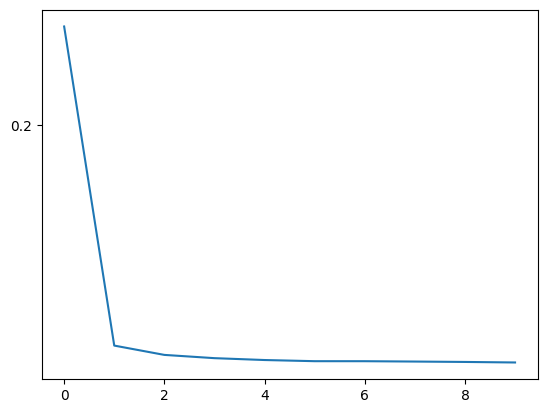

In [60]:
%matplotlib inline

hidden_size = 256
batch_size = 32
n_epochs = 100

# Datos
input_lang_ita_eng, output_lang_ita_eng, train_dataloader_ita_eng = get_dataloader(batch_size, 'eng', 'ita')

# Modelos
encoder_ita_eng = EncoderRNN(input_lang_ita_eng.n_words, hidden_size).to(device)
decoder_ita_eng = AttnDecoderRNN(hidden_size, output_lang_ita_eng.n_words).to(device)

# Entrenamiento
train(train_dataloader_ita_eng, encoder_ita_eng, decoder_ita_eng, n_epochs, print_every=10, plot_every=10)

# Guardar los modelos dentro de la carpeta
torch.save(encoder_ita_eng.state_dict(), os.path.join(folder_path, 'encoder_ita_eng.pth'))
torch.save(decoder_ita_eng.state_dict(), os.path.join(folder_path, 'decoder_ita_eng.pth'))

### Entrenar red de castellano a inglés

Reading lines...
Read 141543 sentence pairs
Trimmed to 9305 sentence pairs
Counting words...
Counted words:
spa 4398
eng 2992
3m 0s (- 27m 2s) (10 10%) 0.7927
6m 0s (- 24m 1s) (20 20%) 0.0788
9m 4s (- 21m 9s) (30 30%) 0.0474
12m 3s (- 18m 5s) (40 40%) 0.0406
15m 3s (- 15m 3s) (50 50%) 0.0365
18m 13s (- 12m 9s) (60 60%) 0.0346
21m 17s (- 9m 7s) (70 70%) 0.0328
24m 28s (- 6m 7s) (80 80%) 0.0316
27m 32s (- 3m 3s) (90 90%) 0.0309
30m 32s (- 0m 0s) (100 100%) 0.0302


<Figure size 640x480 with 0 Axes>

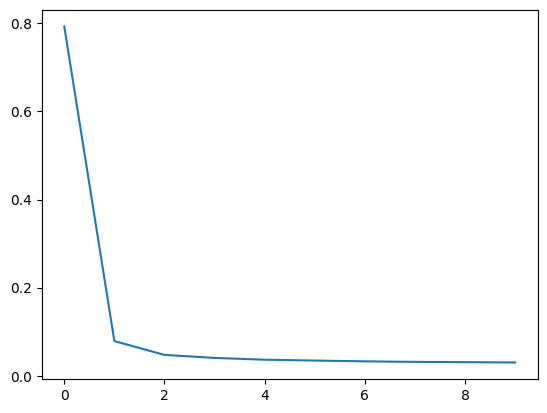

In [61]:
%matplotlib inline

hidden_size = 256
batch_size = 32
n_epochs = 100

# Datos
input_lang_spa_eng, output_lang_spa_eng, train_dataloader_spa_eng = get_dataloader(batch_size, 'eng', 'spa')

# Modelos
encoder_spa_eng = EncoderRNN(input_lang_spa_eng.n_words, hidden_size).to(device)
decoder_spa_eng = AttnDecoderRNN(hidden_size, output_lang_spa_eng.n_words).to(device)

# Entrenamiento
train(train_dataloader_spa_eng, encoder_spa_eng, decoder_spa_eng, n_epochs, print_every=10, plot_every=10)

# Guardar los modelos dentro de la carpeta
torch.save(encoder_spa_eng.state_dict(), os.path.join(folder_path, 'encoder_spa_eng.pth'))
torch.save(decoder_spa_eng.state_dict(), os.path.join(folder_path, 'decoder_spa_eng.pth'))

### Cargar modelos

Una vez entrenados los modelos en el cluster, estos se han guardado en la carpeta *models*. Los descargamos del cluster para poder cargarlos en local ya entrenados, y así evaluar su rendimiento.

In [33]:
# Datos
hidden_size = 256
input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng = prepareData('eng', 'ita', True)

# Cargar los modelos de italiano a inglés previamente guardados
encoder_ita_eng = EncoderRNN(input_lang_ita_eng.n_words, hidden_size).to(device)
decoder_ita_eng = AttnDecoderRNN(hidden_size, output_lang_ita_eng.n_words).to(device)

encoder_ita_eng.load_state_dict(torch.load(os.path.join(folder_path, 'encoder_ita_eng.pth'), map_location=device))
decoder_ita_eng.load_state_dict(torch.load(os.path.join(folder_path, 'decoder_ita_eng.pth'), map_location=device))

Reading lines...
Read 377937 sentence pairs
Trimmed to 34228 sentence pairs
Counting words...
Counted words:
ita 5672
eng 3341


C:\Users\gilpe\AppData\Local\Temp\ipykernel_17972\803734194.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_ita_eng.load_state_dict(torch.load(os.path.join(folde

<All keys matched successfully>

In [32]:
# Datos
hidden_size = 256
input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng = prepareData('eng', 'spa', True)

# Cargar los modelos de castellano a inglés previamente guardados
encoder_spa_eng = EncoderRNN(input_lang_spa_eng.n_words, hidden_size).to(device)
decoder_spa_eng = AttnDecoderRNN(hidden_size, output_lang_spa_eng.n_words).to(device)

encoder_spa_eng.load_state_dict(torch.load(os.path.join(folder_path, 'encoder_spa_eng.pth'), map_location=device))
decoder_spa_eng.load_state_dict(torch.load(os.path.join(folder_path, 'decoder_spa_eng.pth'), map_location=device))

Reading lines...
Read 141543 sentence pairs
Trimmed to 9305 sentence pairs
Counting words...
Counted words:
spa 4398
eng 2992


C:\Users\gilpe\AppData\Local\Temp\ipykernel_17972\4001578575.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_spa_eng.load_state_dict(torch.load(os.path.join(fold

<All keys matched successfully>

### Evaluación

In [26]:
encoder_ita_eng.eval()
decoder_ita_eng.eval()

# Evaluación del modelo de italiano a inglés
evaluateRandomly(encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng)

> ti sto parlando da amica
= i m speaking to you as a friend
< i m speaking to you as a friend <EOS>

> sono qui per salvarvi
= i m here to rescue you
< i m here to rescue you <EOS>

> siamo insegnanti non studentesse
= we re teachers not students
< we re teachers not students <EOS>

> mi dispiace ma non capisco
= i m sorry but i don t understand
< i m sorry but i don t understand <EOS>

> e troppo giovane per preoccuparsi della cellulite
= you re too young to worry about cellulite
< you re too young to worry about cellulite <EOS>

> sto andando a lavorare
= i m going to work
< i m going to work <EOS>

> non sono ancora pronta
= i m still not ready yet
< i not ready yet <EOS>

> siete agitate
= you re agitated
< you are agitated <EOS>

> tu sei molto gradita
= you are very welcome
< you are very welcome <EOS>

> non sono coraggioso quanto tom
= i m not as brave as tom
< i m not as brave as tom <EOS>



In [27]:
encoder_spa_eng.eval()
decoder_spa_eng.eval()

# Evaluación del modelo de castellano a inglés
evaluateRandomly(encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng)

> estan esposados
= they re handcuffed
< they re handcuffed <EOS>

> estoy seguro de que estaras muy comoda ahi
= i am sure you will be very comfortable there
< i am sure you will be very comfortable there <EOS>

> somos parte del problema
= we re part of the problem
< we re part of the problem <EOS>

> no tengo nada que ver en ese asunto
= i am not concerned with the affair
< i am not concerned with the affair <EOS>

> no soy especial
= i m not special
< i m not special <EOS>

> eres tan hermosa !
= you re so beautiful !
< you re so beautiful ! <EOS>

> soy responsable por este fracaso
= i am responsible for this failure
< i am responsible for this failure <EOS>

> somos aventureros
= we re adventurous
< we re adventurous <EOS>

> eres decidida
= you re decisive
< you re decisive <EOS>

> ella siempre esta intentando encontrar la felicidad
= she is always trying to find happiness
< she is always trying to find happiness <EOS>



### Visualización de la atención

In [28]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder, input_lang, output_lang):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = lui non e alto come suo padre
output = he is not as tall as his father <EOS>


C:\Users\JavierGS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
C:\Users\JavierGS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


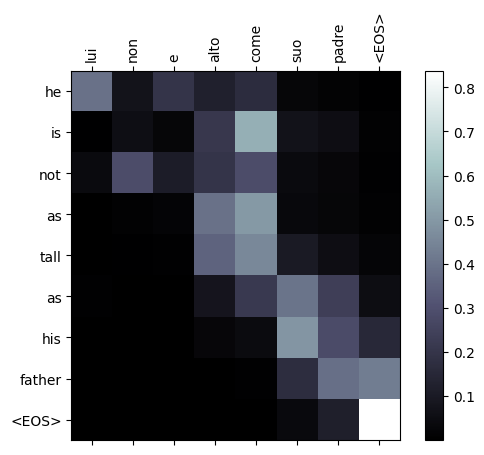

input = sonno troppo stanco per guidare
output = i m too tired to have to drive <EOS>


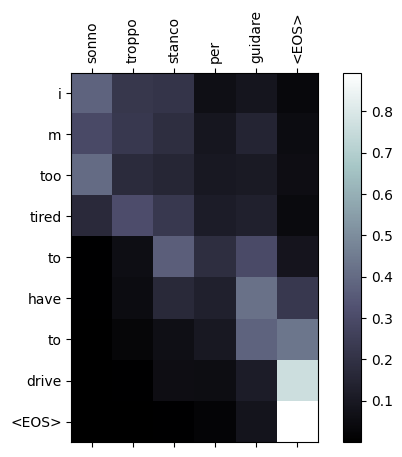

input = mi dispiace se questa e una domanda stupida
output = i m sorry that i m an stupid <EOS>


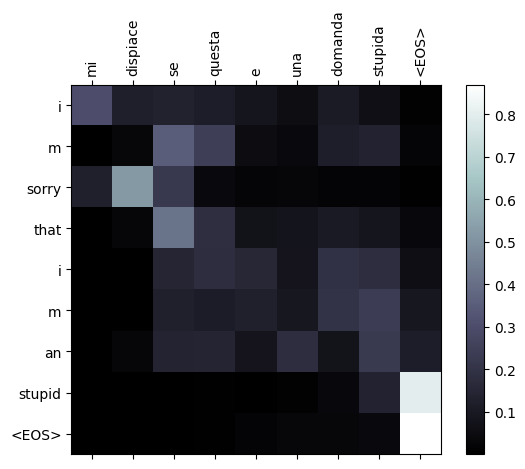

input = sonno davvero fiero di te
output = i m really glad to have you <EOS>


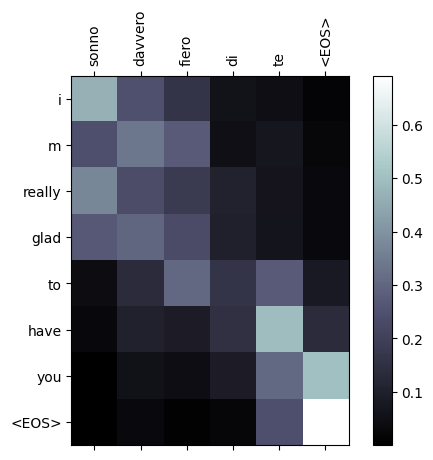

In [29]:
%matplotlib inline

evaluateAndShowAttention('lui non e alto come suo padre', encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng)

evaluateAndShowAttention('sonno troppo stanco per guidare', encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng)

evaluateAndShowAttention('mi dispiace se questa e una domanda stupida', encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng)

evaluateAndShowAttention('sonno davvero fiero di te', encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng)

input = el no es tan alto como su padre
output = he is not as tall as his father <EOS>


C:\Users\JavierGS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == "__main__":
C:\Users\JavierGS\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


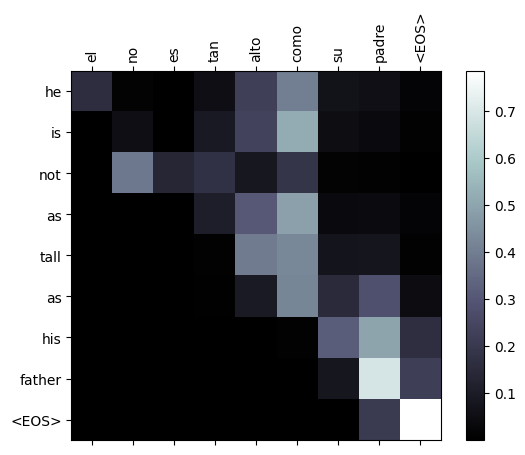

input = estoy demasiado cansado para conducir
output = i m too tired to drive <EOS>


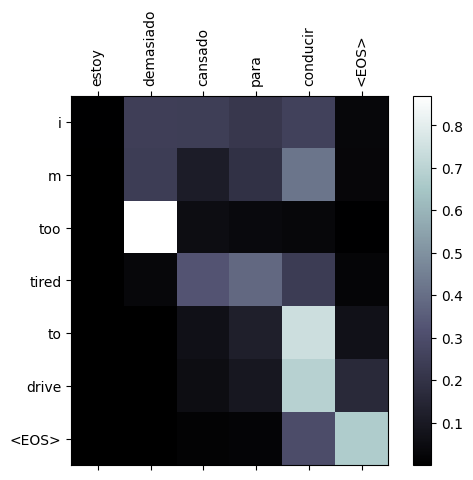

input = lo siento si esta es una pregunta estupida
output = i m sorry if i m an individualist <EOS>


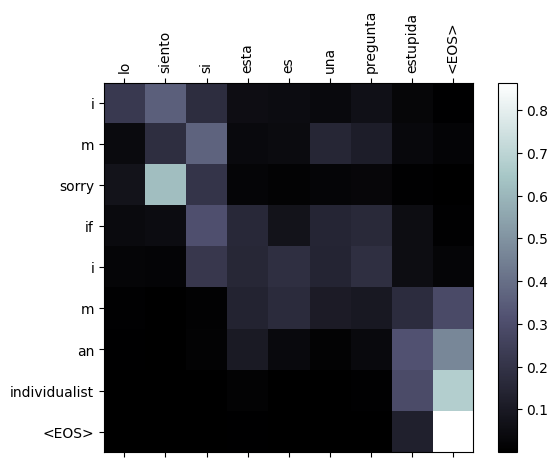

input = estoy muy orgulloso de ti
output = i m very proud of you <EOS>


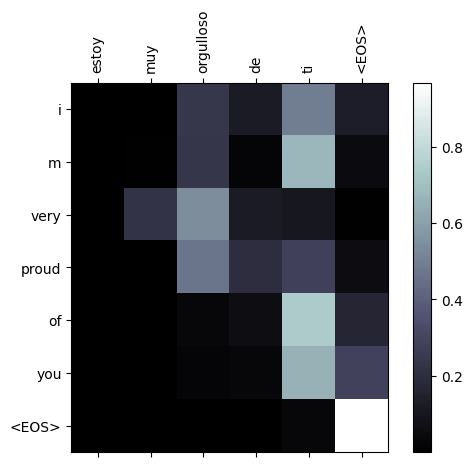

In [30]:
%matplotlib inline

evaluateAndShowAttention('el no es tan alto como su padre', encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng)

evaluateAndShowAttention('estoy demasiado cansado para conducir', encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng)

evaluateAndShowAttention('lo siento si esta es una pregunta estupida', encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng)

evaluateAndShowAttention('estoy muy orgulloso de ti', encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng)

### Métrica 1: BLEU Score

El BLEU Score es una métrica que evalúa la calidad de las traducciones comparando n-gramas de la traducción generada con la traducción de referencia, midiendo la precisión y penalizando traducciones demasiado largas o cortas mediante un factor de brevedad.

In [88]:
def evaluateRandomly_BLEU(encoder, decoder, input_lang, output_lang, pairs, n=10):
    smoothing_function = SmoothingFunction().method4  # Para suavizar el cálculo del BLEU
    total_bleu = 0  # Acumulador para el BLEU promedio

    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])  # Frase original
        # print('=', pair[1])  # Traducción de referencia

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words).replace('<EOS>', '').strip()  # Elimina el token EOS

        # print('<', output_sentence)  # Traducción generada

        # Calcular BLEU
        reference = [pair[1].split()]  # Lista de listas con la traducción de referencia
        candidate = output_sentence.split()  # Traducción generada
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
        total_bleu += bleu_score

        # print(f'BLEU score: {bleu_score:.4f}')  # Mostrar BLEU por oración
        # print('')

    # BLEU promedio para las oraciones evaluadas
    average_bleu = total_bleu / n
    print(f'Average BLEU score over {n} sentences: {average_bleu:.4f}')

In [90]:
encoder_ita_eng.eval()
decoder_ita_eng.eval()

n = 100

# Evaluación del modelo de italiano a inglés
evaluateRandomly_BLEU(encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng, n)

# Evaluación del modelo de castellano a inglés
evaluateRandomly_BLEU(encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng, n)


Average BLEU score over 100 sentences: 0.8295
Average BLEU score over 100 sentences: 0.8578


### Métrica 2: METEOR

La métrica METEOR evalúa la calidad de las traducciones comparando palabras y frases de la salida generada con la frase de referencia, considerando coincidencias exactas, sinónimos, raíces y el orden de las palabras, y priorizando el equilibrio entre precisión y recall.

In [34]:
from nltk.translate.meteor_score import meteor_score

def calculate_meteor(reference, hypothesis):

    # Convertimos las cadenas de texto en listas de palabras
    reference = [reference.split()]
    hypothesis = hypothesis.split()
    
    # Calculamos la métrica METEOR
    score = meteor_score(reference, hypothesis)
    return score

In [85]:
from nltk.translate.meteor_score import meteor_score

def evaluateRandomly_METEOR(encoder, decoder, input_lang, output_lang, pairs, n=10):
    total_meteor = 0  # Acumulador para el METEOR promedio

    for i in range(n):
        pair = random.choice(pairs)
        # print('>', pair[0])  # Frase original
        # print('=', pair[1])  # Traducción de referencia

        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words).replace('<EOS>', '').strip()  # Elimina el token EOS

        # print('<', output_sentence)  # Traducción generada

        # Calcular METEOR
        meteor_score = calculate_meteor(pair[1], output_sentence)
        total_meteor += meteor_score

        # print(f'METEOR score: {meteor_score:.4f}')  # Mostrar METEOR por oración
        # print('')

    # METEOR promedio para las oraciones evaluadas
    average_meteor = total_meteor / n
    print(f'Average METEOR score over {n} sentences: {average_meteor:.4f}')

In [87]:
n = 100
# Evaluación del modelo de italiano a inglés
print("Italiano a inglés:")
evaluateRandomly_METEOR(encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng, n)

# Evaluación del modelo de castellano a inglés
print("Castellano a inglés:")
evaluateRandomly_METEOR(encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng, n)



Italiano a inglés:
Average METEOR score over 100 sentences: 0.9428
Castellano a inglés:
Average METEOR score over 100 sentences: 0.9537


### Métrica 3: ROUGE Score

Las métricas ROUGE son un conjunto de métricas que se pueden utilizar para evaluar modelos de traducción en procesamiento del lenguaje natural. Dichas métricas comparan una traducción generada automáticamente con una traducción de referencia producida por humanos. Las métricas ROUGE oscilan entre 0 y 1, y las puntuaciones más altas indican una mayor similitud entre la traducción generada por el modelo y la referencia. Algunos ejemplos de estas métricas son:

- ROUGE-1: superposición de unigramas entre la traducción generada por el modelo y la traducción de referencia.
- ROUGE-2: superposición de bigramas entre la traducción generada por el modelo y la traducción de referencia.
- ROUGE-L: estadísticas basadas en la subsecuencia común más larga, que identifica los n-gramas más largos que ocurren simultáneamente en las secuencias.

Usando la librería `rouge_score` podemos calcular estas métricas ROUGE para evaluar nuestros modelos.

Para calcular los promedios de las métricas de ROUGE, modificamos la función `evaluateRandomly` para que en cada ejemplo seleccionado aleatoriamente calcule las métricas ROUGE, y al final calcule el promedio de todos los ejemplos. Nos fijaremos principalmente en la métrica F1, ya que esta muestra un equilibrio entre la precisión y el recall, dado que combina ambas. Esto es importante, ya que:

- Precisión: mide la proporción de palabras en la traducción generada que están en la traducción de referencia.
- Recall: mide la proporción de palabras de la traducción de referencia que están en la traducción generada.

In [28]:
from rouge_score import rouge_scorer

def calculate_rouge(output_sentence, reference_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_sentence, output_sentence)
    return scores

In [29]:
def evaluateRandomly_ROUGE(encoder, decoder, input_lang, output_lang, pairs, n=10):
    total_rouge1_f1 = 0
    total_rouge1_precision = 0
    total_rouge1_recall = 0

    total_rouge2_f1 = 0
    total_rouge2_precision = 0
    total_rouge2_recall = 0

    total_rougeL_f1 = 0
    total_rougeL_precision = 0
    total_rougeL_recall = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])  # Texto original
        print('=', pair[1])  # Traducción real
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)  # Traducción generada
        print('<', output_sentence)
        print('')

        # Calcular ROUGE
        rouge_scores = calculate_rouge(output_sentence, pair[1])

        # ROUGE-1
        rouge1_f1 = rouge_scores['rouge1'].fmeasure
        rouge1_precision = rouge_scores['rouge1'].precision
        rouge1_recall = rouge_scores['rouge1'].recall
        total_rouge1_f1 += rouge1_f1
        total_rouge1_precision += rouge1_precision
        total_rouge1_recall += rouge1_recall

        # ROUGE-2
        rouge2_f1 = rouge_scores['rouge2'].fmeasure
        rouge2_precision = rouge_scores['rouge2'].precision
        rouge2_recall = rouge_scores['rouge2'].recall
        total_rouge2_f1 += rouge2_f1
        total_rouge2_precision += rouge2_precision
        total_rouge2_recall += rouge2_recall

        # ROUGE-L
        rougeL_f1 = rouge_scores['rougeL'].fmeasure
        rougeL_precision = rouge_scores['rougeL'].precision
        rougeL_recall = rouge_scores['rougeL'].recall
        total_rougeL_f1 += rougeL_f1
        total_rougeL_precision += rougeL_precision
        total_rougeL_recall += rougeL_recall

        print(f'ROUGE-1 - Precision: {rouge1_precision:.4f}, Recall: {rouge1_recall:.4f}, F1: {rouge1_f1:.4f}')
        print(f'ROUGE-2 - Precision: {rouge2_precision:.4f}, Recall: {rouge2_recall:.4f}, F1: {rouge2_f1:.4f}')
        print(f'ROUGE-L - Precision: {rougeL_precision:.4f}, Recall: {rougeL_recall:.4f}, F1: {rougeL_f1:.4f}')
        print('')

    # Calcular promedios
    avg_rouge1_f1 = total_rouge1_f1 / n
    avg_rouge1_precision = total_rouge1_precision / n
    avg_rouge1_recall = total_rouge1_recall / n

    avg_rouge2_f1 = total_rouge2_f1 / n
    avg_rouge2_precision = total_rouge2_precision / n
    avg_rouge2_recall = total_rouge2_recall / n

    avg_rougeL_f1 = total_rougeL_f1 / n
    avg_rougeL_precision = total_rougeL_precision / n
    avg_rougeL_recall = total_rougeL_recall / n

    print(f'Average ROUGE-1 - Precision: {avg_rouge1_precision:.4f}, Recall: {avg_rouge1_recall:.4f}, F1: {avg_rouge1_f1:.4f}')
    print(f'Average ROUGE-2 - Precision: {avg_rouge2_precision:.4f}, Recall: {avg_rouge2_recall:.4f}, F1: {avg_rouge2_f1:.4f}')
    print(f'Average ROUGE-L - Precision: {avg_rougeL_precision:.4f}, Recall: {avg_rougeL_recall:.4f}, F1: {avg_rougeL_f1:.4f}')

In [30]:
encoder_ita_eng.eval()
decoder_ita_eng.eval()

# Evaluación del modelo de italiano a inglés
evaluateRandomly_ROUGE(encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng)

> sono qualificato quasi quanto tom
= i m about as qualified as tom is
< i m about as qualified as tom is <EOS>

ROUGE-1 - Precision: 0.8889, Recall: 1.0000, F1: 0.9412
ROUGE-2 - Precision: 0.8750, Recall: 1.0000, F1: 0.9333
ROUGE-L - Precision: 0.8889, Recall: 1.0000, F1: 0.9412

> voi siete sofisticati
= you re sophisticated
< you re sophisticated <EOS>

ROUGE-1 - Precision: 0.7500, Recall: 1.0000, F1: 0.8571
ROUGE-2 - Precision: 0.6667, Recall: 1.0000, F1: 0.8000
ROUGE-L - Precision: 0.7500, Recall: 1.0000, F1: 0.8571

> sto studiando francese adesso
= i m studying french now
< i m studying french now <EOS>

ROUGE-1 - Precision: 0.8333, Recall: 1.0000, F1: 0.9091
ROUGE-2 - Precision: 0.8000, Recall: 1.0000, F1: 0.8889
ROUGE-L - Precision: 0.8333, Recall: 1.0000, F1: 0.9091

> abbiamo circa la stessa eta
= we re about the same age
< we re about the same age <EOS>

ROUGE-1 - Precision: 0.8571, Recall: 1.0000, F1: 0.9231
ROUGE-2 - Precision: 0.8333, Recall: 1.0000, F1: 0.9091
ROUGE-L -

In [31]:
encoder_spa_eng.eval()
decoder_spa_eng.eval()

# Evaluación del modelo de castellano a inglés
evaluateRandomly_ROUGE(encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng)

> manana voy a comprar algunos libros
= i m going to buy some books tomorrow
< i m going to buy some books tomorrow <EOS>

ROUGE-1 - Precision: 0.8889, Recall: 1.0000, F1: 0.9412
ROUGE-2 - Precision: 0.8750, Recall: 1.0000, F1: 0.9333
ROUGE-L - Precision: 0.8889, Recall: 1.0000, F1: 0.9412

> yo sospecho de el
= i am suspicious of him
< i am suspicious of him <EOS>

ROUGE-1 - Precision: 0.8333, Recall: 1.0000, F1: 0.9091
ROUGE-2 - Precision: 0.8000, Recall: 1.0000, F1: 0.8889
ROUGE-L - Precision: 0.8333, Recall: 1.0000, F1: 0.9091

> te voy a traer tus pastillas
= i m going to get your pills
< i m going to get your pills <EOS>

ROUGE-1 - Precision: 0.8750, Recall: 1.0000, F1: 0.9333
ROUGE-2 - Precision: 0.8571, Recall: 1.0000, F1: 0.9231
ROUGE-L - Precision: 0.8750, Recall: 1.0000, F1: 0.9333

> puede acompanarnos
= you re welcome to accompany us
< you re welcome to accompany us <EOS>

ROUGE-1 - Precision: 0.8571, Recall: 1.0000, F1: 0.9231
ROUGE-2 - Precision: 0.8333, Recall: 1.0000, 

Al observar los valores obtenidos para el ROUGE Score, vemos que ambos modelos logran un buen desempeño. Sin embargo, el traductor de italiano a inglés presenta un recall perfecto, lo cual podría indicar que el modelo ha memorizado las referencias del conjunto de entrenamiento, y que no está generalizando, es decir, que tal vez sea debido a que hay overfitting.

### Métrica 4: BERT Score

El BERT score es una métrica usada para evaluar la calidad de un texto generado por un modelo de lenguaje, que se basa en la similitud semántica entre el texto generado y el de referencia, utilizando los embeddings generados por el modelo de BERT. Este modelo proporciona embeddings contextuales a las palabras de una frase, de forma que genera embeddings diferentes para una misma palabra dependiendo de las palabras a su alrededor y del contexto general de la frase. Esto permite al BERT score capturar de manera más efectiva el significado de las palabras dentro de un contexto, incluso si las palabras exactas en el texto generado y el de referencia no coinciden.

In [24]:
from bert_score import score
from transformers import logging
logging.set_verbosity_error()

def calculate_bertscore(output_sentence, reference_sentence):
    P, R, F1 = score([output_sentence], [reference_sentence], lang="en")
    return {"Precision": P.item(), "Recall": R.item(), "F1": F1.item()}

In [25]:
def evaluateRandomly_BERT(encoder, decoder, input_article, output_abstract, pairs, n=10):
    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])  # Texto original
        print('=', pair[1])  # Traducción real
        output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
        output_sentence = ' '.join(output_words)  # Traducción generada
        print('<', output_sentence)
        print('')

        # Calcular BERT Score
        bert_scores = calculate_bertscore(output_sentence, pair[1])
        precision = bert_scores['Precision']
        recall = bert_scores['Recall']
        f1 = bert_scores['F1']

        total_precision += precision
        total_recall += recall
        total_f1 += f1

        print(f'BERTScore Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        print('')
    
    # Calcular promedios
    avg_precision = total_precision / n
    avg_recall = total_recall / n
    avg_f1 = total_f1 / n

    print(f'Average BERTScore Precision over {n} sentences: {avg_precision:.4f}')
    print(f'Average BERTScore Recall over {n} sentences: {avg_recall:.4f}')
    print(f'Average BERTScore F1 over {n} sentences: {avg_f1:.4f}')

In [26]:
encoder_ita_eng.eval()
decoder_ita_eng.eval()

# Evaluación del modelo de italiano a inglés
evaluateRandomly_BERT(encoder_ita_eng, decoder_ita_eng, input_lang_ita_eng, output_lang_ita_eng, pairs_ita_eng)

> non sono il capo
= i m not the boss
< i m not the boss <EOS>

BERTScore Precision: 0.8888, Recall: 0.9618, F1: 0.9239

> io sono il supervisore
= i m the supervisor
< i m the supervisor <EOS>

BERTScore Precision: 0.8807, Recall: 0.9599, F1: 0.9186

> non sono un ladro
= i m not a thief
< i m not a thief <EOS>

BERTScore Precision: 0.8853, Recall: 0.9653, F1: 0.9236

> sono ancora ricca
= i m still rich
< i m still rich <EOS>

BERTScore Precision: 0.8830, Recall: 0.9867, F1: 0.9320

> io sono sbronzo
= i m drunk
< i m drunk <EOS>

BERTScore Precision: 0.8493, Recall: 0.9408, F1: 0.8927

> io sono scrupolosa
= i m thorough
< i m thorough <EOS>

BERTScore Precision: 0.8482, Recall: 0.9061, F1: 0.8762

> sta venendo
= he s coming
< he s coming <EOS>

BERTScore Precision: 0.8598, Recall: 0.9769, F1: 0.9146

> sono spietato
= i m ruthless
< i m ruthless <EOS>

BERTScore Precision: 0.8036, Recall: 0.8624, F1: 0.8320

> non ne sono convinto
= i m not convinced of that
< i m not convinced of

In [27]:
encoder_spa_eng.eval()
decoder_spa_eng.eval()

# Evaluación del modelo de castellano a inglés
evaluateRandomly_BERT(encoder_spa_eng, decoder_spa_eng, input_lang_spa_eng, output_lang_spa_eng, pairs_spa_eng)

> no estoy mintiendo
= i m not lying
< i m not lying <EOS>

BERTScore Precision: 0.8621, Recall: 0.9551, F1: 0.9062

> ahora estoy jugando voleibol
= i am playing volleyball now
< i am playing volleyball now <EOS>

BERTScore Precision: 0.9069, Recall: 0.9747, F1: 0.9396

> el esta loco por ti
= he s crazy about you
< he s crazy about you <EOS>

BERTScore Precision: 0.8998, Recall: 0.9948, F1: 0.9449

> el siempre esta pidiendo dinero
= he is always asking for money
< he is always asking for money <EOS>

BERTScore Precision: 0.9092, Recall: 0.9923, F1: 0.9490

> soy un pro
= i m a pro
< i m a pro <EOS>

BERTScore Precision: 0.8657, Recall: 0.9554, F1: 0.9083

> es sensible al calor
= she is sensitive to the heat
< she is sensitive to the heat <EOS>

BERTScore Precision: 0.9017, Recall: 0.9784, F1: 0.9385

> ellas estan volviendo
= they re coming back
< they re coming back <EOS>

BERTScore Precision: 0.8710, Recall: 0.9813, F1: 0.9229

> estoy muy preocupado por ti
= i m very worried abo

Observamos que para ambos modelos se obtienen valores bastante elevados de BERT Score, lo que indica que se están generando traducciones de alta calidad y con un alto nivel de similitud semántica respecto a las referencias originales. Los valores elevados de precisión sugieren que las palabras generadas por los modelos están bien alineadas con el significado y contexto de las referencias, mientras que los valores de recall indican que las traducciones abarcan la mayor parte del contenido relevante esperado. El F1 Score confirma un equilibrio sólido entre ambos aspectos.